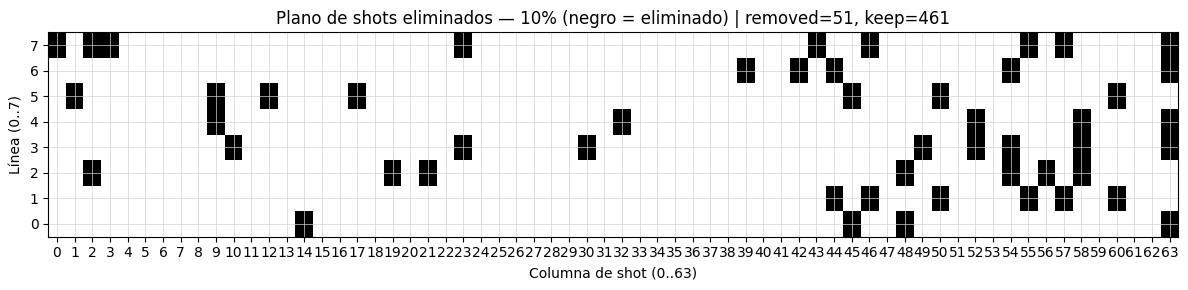

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("/home/pc-2/Documents/CAVE_minciencias/final_model/resultados_STE/pct_10/run_pct10.npz", allow_pickle=True)
removed_idx = data["removed_idx"]

n_lines = 8
n_cols = 64
total = n_lines * n_cols

mask_grid = np.zeros((n_lines, n_cols), dtype=int)

for idx in removed_idx:
    # INVERTIR LAS LÍNEAS:
    line = n_lines - 1 - (idx // n_cols)   # antes: line = idx // n_cols
    col  = idx % n_cols
    mask_grid[line, col] = 1

removed = len(removed_idx)
keep = total - removed

plt.figure(figsize=(12, 3))
plt.imshow(
    mask_grid,
    cmap="gray_r",
    origin="lower",         # ahora line=7 queda arriba, line=0 abajo
    extent=[-0.5, n_cols - 0.5, -0.5, n_lines - 0.5],
    aspect="auto"
)

plt.title(f"Plano de shots eliminados — 10% (negro = eliminado) | removed={removed}, keep={keep}")
plt.xlabel("Columna de shot (0..63)")
plt.ylabel("Línea (0..7)")
plt.xticks(np.arange(0, n_cols, 1))
plt.yticks(np.arange(0, n_lines, 1))
plt.grid(color="lightgray", linewidth=0.5)

plt.tight_layout()
plt.show()


## Submuestreo capa binaria entrenable

In [ ]:
import os, re, glob, numpy as np
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

BASE_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_sinteticos_finales2D"
OUT_DIR  = os.path.join("/home/pc-2/Documents/CAVE_minciencias/final_model/", "salidas_crg_shotmask_ste")
os.makedirs(OUT_DIR, exist_ok=True)

H, W = 512, 4096
BATCH = 1
EPOCHS = 3
LR = 1e-4
GLOBAL_SEED = 42
LAMBDA_SPARSITY = 10
#SCENARIOS = [10,20,30,40,50,60,70,80,90]
SCENARIOS = [10]

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def crop_to_mult8_2d(arr):
    S, T = arr.shape[-2], arr.shape[-1]
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[..., :S8, :T8].copy()
    return arr

def check_divisible_by_8(h, w):
    for val, nm in [(h, "H(shots)"), (w, "W(time)")]:
        assert val % 8 == 0, f"{nm} debe ser múltiplo de 8 para U-Net: {val}"

def tag(fname):
    m = re.search(r'shot_(y\d{2})_', os.path.basename(fname).lower())
    return m.group(1) if m else None

def load_all(base_dir):
    pats = ["shot_y0[1-8]_*.sgy", "shot_y0[1-8]_*.segy"]
    files = sorted(sum([glob.glob(os.path.join(base_dir, p)) for p in pats], []))
    files = [f for f in files if tag(f) is not None]
    arrs = []
    for f in files:
        st = _read_segy(f, headonly=False)
        A = np.array([tr.data for tr in st.traces], dtype=np.float32)
        arrs.append(A)
    return np.stack(arrs, 0), files

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def count_params(model): return sum(p.numel() for p in model.parameters())

class BinaryShotMaskSTE(nn.Module):
    """
    Aprende una prob(keep) por SHOT y elimina K = round(frac_remove * S) disparos
    (las filas con menor prob(keep)), usando Straight-Through Estimator (STE).
    """
    def __init__(self, n_shots, init_keep_prob=0.9):
        super().__init__()
        self.n_shots = int(n_shots)
        init_keep_prob = float(np.clip(init_keep_prob, 1e-3, 1-1e-3))
        init_logit = np.log(init_keep_prob/(1-init_keep_prob))
        self.logits = nn.Parameter(torch.full((self.n_shots,), float(init_logit)))
        self.frac_remove = 0.10

    def set_frac_remove(self, frac):
        self.frac_remove = float(np.clip(frac, 0.0, 1.0))

    def forward(self, x):
        """
        x: (B, 1, S, T)  -> enmascara la dimensión S (shots)
        devuelve: x_masked, probs(sigmoid), hard(0/1 por shot)
        """
        assert x.dim()==4 and x.shape[2]==self.n_shots, f"Esperaba S={self.n_shots}, got {x.shape}"
        probs = torch.sigmoid(self.logits)
        K = int(round(self.frac_remove * self.n_shots))
        if K > 0:
            idx_del = torch.topk(probs, K, largest=False).indices
            hard = torch.ones_like(probs); hard[idx_del] = 0.0
        else:
            hard = torch.ones_like(probs)
        ste_mask = hard + probs - probs.detach()
        x_masked = x * ste_mask.view(1,1,self.n_shots,1)
        return x_masked, probs, hard

    @torch.no_grad()
    def hard_indices_removed(self):
        probs = torch.sigmoid(self.logits)
        K = int(round(self.frac_remove * self.n_shots))
        if K <= 0: return np.array([], dtype=int)
        idx_del = torch.topk(probs, K, largest=False).indices
        return idx_del.cpu().numpy()

print(">>> Cargando archivos...")
gathers_shot, file_list = load_all(BASE_DIR)
print(f">>> Cargados {len(file_list)} shots.")

assert gathers_shot.shape[1] >= H and gathers_shot.shape[2] >= W, "Dimensiones < H/W"
gathers_shot = gathers_shot[:, :H, :W].copy()

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
CRG_all = norm_trace_lastaxis(CRG_all)
CRG_all = crop_to_mult8_2d(CRG_all)
S8, T8 = CRG_all.shape[1], CRG_all.shape[2]
check_divisible_by_8(S8, T8)

idx_rec = np.arange(CRG_all.shape[0])
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=42, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]
print(">>> Datos preparados (CRG, normalización, split).")

def train_unet_with_shotmask(CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR):
    """
    Entrena U-Net con máscara binaria entrenable en dimensión SHOTS (STE).
    Loss = (1-SSIM) + lambda_sparsity * (keep_mean - target_keep)^2
    """
    S = CRG_tr.shape[1]
    target_keep = 1.0 - (pct/100.0)

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    Yt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)

    loader = DataLoader(TensorDataset(Xt, Yt), batch_size=batch_size, shuffle=True)

    model = UNet2DFull().to(device)
    mask_layer = BinaryShotMaskSTE(n_shots=S, init_keep_prob=max(0.05, min(0.95, target_keep))).to(device)
    mask_layer.set_frac_remove(pct/100.0)

    opt = torch.optim.Adam([
        {"params": model.parameters(), "lr": lr},
        {"params": mask_layer.parameters(), "lr": lr}
    ])
    crit = SSIM(data_range=2.0, size_average=True, channel=1)

    loss_hist = []
    model.train()
    for _ in range(epochs):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xb_masked, probs, hard = mask_layer(xb)       # enmascara SHOTS
            yp = model(xb_masked)
            loss_rec = 1 - crit(yp, yb)

            keep_mean = torch.sigmoid(mask_layer.logits).mean()
            loss_sp = (keep_mean - target_keep) ** 2

            loss = loss_rec + LAMBDA_SPARSITY * loss_sp
            loss.backward(); opt.step()
            run += float(loss.item())
        loss_hist.append(run / len(loader))

    return model, mask_layer, loss_hist

def eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2):
    """
    Métricas SOLO sobre los shots eliminados (filas cero en la entrada por máscara).
    Calcula MSE, PSNR, SSIM, SNR promediando sobre CRGs de test y shots eliminados.
    """
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}

    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)

            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)

            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]

            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12) / (mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)

            del xb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def viz_shot_real_vs_pred_minibatch_masked(model, removed_idx, CRG_all, shot_idx,
                                           save_dir, file_stub, vmin=-1, vmax=1, binf=2):
    os.makedirs(save_dir, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    Htot, S, T = CRG_all.shape
    pred_shot = np.zeros((Htot, T), dtype=np.float32)
    real_shot = CRG_all[:, shot_idx, :].copy()

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred_shot[i0:i1, :] = yb[:, shot_idx, :]
            del xb, yb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    err = np.abs(pred_shot - real_shot)
    fig1 = plt.figure(figsize=(18, 5))
    ax1 = fig1.add_subplot(1,3,1)
    im0 = ax1.imshow(pred_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}")
    ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo"); fig1.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig1.add_subplot(1,3,2)
    im1 = ax2.imshow(real_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}")
    ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo"); fig1.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig1.add_subplot(1,3,3)
    im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto', origin='upper')
    ax3.set_title("Error absoluto")
    ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo"); fig1.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)

    fig1.tight_layout()
    fig1.savefig(os.path.join(save_dir, f"{file_stub}_maps.png"), dpi=150)
    plt.close(fig1)

    recs = np.linspace(0, pred_shot.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred_shot.shape[1])
    fig2 = plt.figure(figsize=(16,4))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real_shot[r], label="Real", linewidth=1.5)
        ax.plot(t, pred_shot[r], label="Predicho", linewidth=1.2)
        ax.set_title(f"Shot {shot_idx} | Rec {r}")
        ax.set_xlabel("Tiempo"); ax.set_ylabel("Amplitud")
        ax.grid(True); ax.legend()
    fig2.tight_layout()
    fig2.savefig(os.path.join(save_dir, f"{file_stub}_traces.png"), dpi=150)
    plt.close(fig2)

def save_mask_bars(removed_idx, S, save_path, height=40, title=None):
    mask = np.ones(S, dtype=np.float32)
    mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32)
    img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(14, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice 0..S-1)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

def save_npz_per_pct(pct, probs, hard, logits, removed_idx, loss_hist, metrics_dict, out_dir):
    path = os.path.join(out_dir, f"run_pct{pct:02d}.npz")
    np.savez_compressed(
        path,
        probs=np.asarray(probs, dtype=np.float32),
        hard=np.asarray(hard, dtype=np.float32),
        logits=np.asarray(logits, dtype=np.float32),
        removed_idx=np.asarray(removed_idx, dtype=np.int32),
        loss_hist=np.asarray(loss_hist, dtype=np.float32),
        MSE=(metrics_dict.get("MSE") if metrics_dict else None),
        PSNR=(metrics_dict.get("PSNR") if metrics_dict else None),
        SSIM=(metrics_dict.get("SSIM") if metrics_dict else None),
        SNR=(metrics_dict.get("SNR") if metrics_dict else None),
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dict_losses = {}
dict_metrics = {}
dict_removed_counts = {}

for pct in SCENARIOS:
    print(f">>> Escenario {pct}%: preparando datos y modelo...")
    model, mask_layer, loss_hist = train_unet_with_shotmask(CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR)
    dict_losses[str(pct)] = loss_hist

    print(f">>> Escenario {pct}%: inferencia, métricas y guardado de figuras...")
    removed_idx = mask_layer.hard_indices_removed()
    dict_removed_counts[str(pct)] = int(len(removed_idx))
    S = CRG_all.shape[1]

    sc_dir = os.path.join(OUT_DIR, f"pct_{pct:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    save_mask_bars(removed_idx, S, os.path.join(sc_dir, "mask_bars.png"),
                   title=f"Máscara de shots — {pct}% eliminados")

    shots_sel = removed_idx[:min(3, len(removed_idx))] if len(removed_idx) > 0 else []
    for s in shots_sel:
        viz_shot_real_vs_pred_minibatch_masked(
            model, removed_idx, CRG_all, s,
            save_dir=sc_dir, file_stub=f"shot_{s}"
        )

    metrics = eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2)
    dict_metrics[str(pct)] = metrics

    with torch.no_grad():
        probs_np = torch.sigmoid(mask_layer.logits).detach().cpu().numpy()
        hard_np  = np.ones_like(probs_np, dtype=np.float32);
        hard_np[removed_idx] = 0.0
        logits_np = mask_layer.logits.detach().cpu().numpy()
    save_npz_per_pct(pct, probs_np, hard_np, logits_np, removed_idx, loss_hist, metrics, sc_dir)

print(">>> Guardando gráfico de pérdidas (todos los escenarios)...")
fig = plt.figure(figsize=(10,7))
for k in sorted(dict_losses.keys(), key=lambda z: int(z)):
    curve = dict_losses[k]
    plt.plot(range(1, len(curve)+1), curve, marker='o', label=f"{k}%")
plt.title("Curva de pérdida (1-SSIM + λ·sparsity) — escenarios 10–90% (mask SHOTS)")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.grid(True); plt.legend(title="Submuestreo", ncol=3)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_curves_shotmask_10_90.png"), dpi=150)
plt.close(fig)

rows = []
for k in sorted(dict_metrics.keys(), key=lambda z: int(z)):
    m = dict_metrics[k] or {}
    rows.append({
        "pct_removed": int(k),
        "shots_removed_count": dict_removed_counts.get(k, np.nan),
        "MSE": m.get("MSE", None),
        "PSNR": m.get("PSNR", None),
        "SSIM": m.get("SSIM", None),
        "SNR": m.get("SNR", None),
    })

df = pd.DataFrame(rows).sort_values("pct_removed").replace({None: np.nan})
csv_path = os.path.join(OUT_DIR, "metrics_removed_shots_10_90.csv")
df.to_csv(csv_path, index=False, float_format="%.6f")

print(">>> Listo.")
print(">>> Figuras y NPZ en:", OUT_DIR)
print(">>> Tabla de métricas CSV:", csv_path)

>>> Cargando archivos...
>>> Cargados 512 shots.
>>> Datos preparados (CRG, normalización, split).
>>> Escenario 10%: preparando datos y modelo...
>>> Escenario 10%: inferencia, métricas y guardado de figuras...
>>> Guardando gráfico de pérdidas (todos los escenarios)...
>>> Listo.
>>> Figuras y NPZ en: /home/pc-2/Documents/CAVE_minciencias/final_model/salidas_crg_shotmask_ste
>>> Tabla de métricas CSV: /home/pc-2/Documents/CAVE_minciencias/final_model/salidas_crg_shotmask_ste/metrics_removed_shots_10_90.csv


## Submuestro Random

In [ ]:
import os, re, glob, numpy as np
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

BASE_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_sinteticos_finales2D"
OUT_DIR  = os.path.join("/home/pc-2/Documents/CAVE_minciencias/final_model/", "salidas_crg_shotmask_random")
os.makedirs(OUT_DIR, exist_ok=True)

H, W = 512, 4096
BATCH = 1
EPOCHS = 40
LR = 1e-4
GLOBAL_SEED = 42
SCENARIOS = [10,20,30,40,50,60,70,80,90]

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def crop_to_mult8_2d(arr):
    S, T = arr.shape[-2], arr.shape[-1]
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[..., :S8, :T8].copy()
    return arr

def check_divisible_by_8(h, w):
    for val, nm in [(h, "H(shots)"), (w, "W(time)")]:
        assert val % 8 == 0, f"{nm} debe ser múltiplo de 8 para U-Net: {val}"

def tag(fname):
    m = re.search(r'shot_(y\d{2})_', os.path.basename(fname).lower())
    return m.group(1) if m else None

def load_all(base_dir):
    pats = ["shot_y0[1-8]_*.sgy", "shot_y0[1-8]_*.segy"]
    files = sorted(sum([glob.glob(os.path.join(base_dir, p)) for p in pats], []))
    files = [f for f in files if tag(f) is not None]
    arrs = []
    for f in files:
        st = _read_segy(f, headonly=False)
        A = np.array([tr.data for tr in st.traces], dtype=np.float32)
        arrs.append(A)
    return np.stack(arrs, 0), files

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def count_params(model): return sum(p.numel() for p in model.parameters())

print(">>> Cargando archivos...")
gathers_shot, file_list = load_all(BASE_DIR)
print(f">>> Cargados {len(file_list)} shots.")

assert gathers_shot.shape[1] >= H and gathers_shot.shape[2] >= W, "Dimensiones < H/W"
gathers_shot = gathers_shot[:, :H, :W].copy()

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
CRG_all = norm_trace_lastaxis(CRG_all)
CRG_all = crop_to_mult8_2d(CRG_all)
S8, T8 = CRG_all.shape[1], CRG_all.shape[2]
check_divisible_by_8(S8, T8)

idx_rec = np.arange(CRG_all.shape[0])
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=42, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]
print(">>> Datos preparados (CRG, normalización, split).")

def train_unet_with_random_mask(CRG_tr, pct, device, epochs=BATCH, batch_size=BATCH, lr=LR):
    """
    Entrena U-Net como autoencoder en CRG con una máscara ALEATORIA FIJA por escenario (SIN STE).
    La entrada se enmascara poniendo a cero los shots eliminados; el objetivo es el CRG completo.
    Loss = (1 - SSIM)
    """
    S = CRG_tr.shape[1]
    K = int(round((pct/100.0) * S))

    rng = np.random.default_rng(GLOBAL_SEED + int(pct))
    removed_idx = np.sort(rng.choice(S, size=K, replace=False)) if K > 0 else np.array([], dtype=int)

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    Yt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)

    loader = DataLoader(TensorDataset(Xt, Yt), batch_size=batch_size, shuffle=True)

    model = UNet2DFull().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)

    loss_hist = []
    model.train()
    for _ in range(epochs):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xb_masked = xb.clone()
            if removed_idx.size > 0:
                xb_masked[:,:,removed_idx,:] = 0.0
            yp = model(xb_masked)
            loss_rec = 1 - crit(yp, yb)
            loss_rec.backward(); opt.step()
            run += float(loss_rec.item())
        loss_hist.append(run / len(loader))

    return model, removed_idx, loss_hist

def eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2):
    """
    Métricas SOLO sobre los shots eliminados (filas cero en la entrada por máscara).
    Calcula MSE, PSNR, SSIM, SNR promediando sobre CRGs de test y shots eliminados.
    """
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}

    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)

            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]

            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12) / (mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)

            del xb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def viz_shot_real_vs_pred_minibatch_masked(model, removed_idx, CRG_all, shot_idx,
                                           save_dir, file_stub, vmin=-1, vmax=1, binf=2):
    os.makedirs(save_dir, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    Htot, S, T = CRG_all.shape
    pred_shot = np.zeros((Htot, T), dtype=np.float32)
    real_shot = CRG_all[:, shot_idx, :].copy()

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred_shot[i0:i1, :] = yb[:, shot_idx, :]
            del xb, yb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    err = np.abs(pred_shot - real_shot)
    fig1 = plt.figure(figsize=(18, 5))
    ax1 = fig1.add_subplot(1,3,1)
    im0 = ax1.imshow(pred_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}")
    ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo"); fig1.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig1.add_subplot(1,3,2)
    im1 = ax2.imshow(real_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}")
    ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo"); fig1.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig1.add_subplot(1,3,3)
    im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto', origin='upper')
    ax3.set_title("Error absoluto")
    ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo"); fig1.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)

    fig1.tight_layout()
    fig1.savefig(os.path.join(save_dir, f"{file_stub}_maps.png"), dpi=150)
    plt.close(fig1)

    recs = np.linspace(0, pred_shot.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred_shot.shape[1])
    fig2 = plt.figure(figsize=(16,4))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real_shot[r], label="Real", linewidth=1.5)
        ax.plot(t, pred_shot[r], label="Predicho", linewidth=1.2)
        ax.set_title(f"Shot {shot_idx} | Rec {r}")
        ax.set_xlabel("Tiempo"); ax.set_ylabel("Amplitud")
        ax.grid(True); ax.legend()
    fig2.tight_layout()
    fig2.savefig(os.path.join(save_dir, f"{file_stub}_traces.png"), dpi=150)
    plt.close(fig2)

def save_mask_bars(removed_idx, S, save_path, height=40, title=None):
    mask = np.ones(S, dtype=np.float32)
    mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32)
    img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(14, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice 0..S-1)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

def save_npz_per_pct_random(pct, removed_idx, loss_hist, metrics_dict, out_dir):
    """
    Guardado estilo compatible con tu flujo original.
    Como no hay STE, los campos probs/logits se guardan como None y 'hard'
    es el vector binario 1=keep/0=removed.
    """
    path = os.path.join(out_dir, f"run_pct{pct:02d}.npz")
    S = (removed_idx.max() + 1) if removed_idx.size > 0 else 0
    hard = None
    if metrics_dict is not None:
        hard = None

    np.savez_compressed(
        path,
        probs=None,
        hard=None,
        logits=None,
        removed_idx=np.asarray(removed_idx, dtype=np.int32),
        loss_hist=np.asarray(loss_hist, dtype=np.float32),
        MSE=(metrics_dict.get("MSE") if metrics_dict else None),
        PSNR=(metrics_dict.get("PSNR") if metrics_dict else None),
        SSIM=(metrics_dict.get("SSIM") if metrics_dict else None),
        SNR=(metrics_dict.get("SNR") if metrics_dict else None),
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dict_losses = {}
dict_metrics = {}
dict_removed_counts = {}

for pct in SCENARIOS:
    print(f">>> Escenario {pct}%: preparando datos y modelo...")
    model, removed_idx, loss_hist = train_unet_with_random_mask(CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR)
    dict_losses[str(pct)] = loss_hist

    print(f">>> Escenario {pct}%: inferencia, métricas y guardado de figuras...")
    dict_removed_counts[str(pct)] = int(len(removed_idx))
    S = CRG_all.shape[1]

    sc_dir = os.path.join(OUT_DIR, f"pct_{pct:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    save_mask_bars(removed_idx, S, os.path.join(sc_dir, "mask_bars.png"),
                   title=f"Máscara de shots — {pct}% eliminados")

    shots_sel = removed_idx[:min(3, len(removed_idx))] if len(removed_idx) > 0 else []
    for s in shots_sel:
        viz_shot_real_vs_pred_minibatch_masked(
            model, removed_idx, CRG_all, s,
            save_dir=sc_dir, file_stub=f"shot_{s}"
        )

    metrics = eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2)
    dict_metrics[str(pct)] = metrics

    save_npz_per_pct_random(pct, removed_idx, loss_hist, metrics, sc_dir)
    hard_vec = np.ones(S, dtype=np.float32)
    hard_vec[removed_idx] = 0.0
    np.savez_compressed(os.path.join(sc_dir, f"run_pct{pct:02d}.npz"),
                        probs=None,
                        hard=hard_vec,
                        logits=None,
                        removed_idx=np.asarray(removed_idx, dtype=np.int32),
                        loss_hist=np.asarray(loss_hist, dtype=np.float32),
                        MSE=(metrics.get("MSE") if metrics else None),
                        PSNR=(metrics.get("PSNR") if metrics else None),
                        SSIM=(metrics.get("SSIM") if metrics else None),
                        SNR=(metrics.get("SNR") if metrics else None))

print(">>> Guardando gráfico de pérdidas (todos los escenarios)...")
fig = plt.figure(figsize=(10,7))
for k in sorted(dict_losses.keys(), key=lambda z: int(z)):
    curve = dict_losses[k]
    plt.plot(range(1, len(curve)+1), curve, marker='o', label=f"{k}%")
plt.title("Curva de pérdida (1-SSIM) — escenarios 10–90% (mask SHOTS ALEATORIA)")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.grid(True); plt.legend(title="Submuestreo", ncol=3)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_curves_shotmask_10_90.png"), dpi=150)
plt.close(fig)

rows = []
for k in sorted(dict_metrics.keys(), key=lambda z: int(z)):
    m = dict_metrics[k] or {}
    rows.append({
        "pct_removed": int(k),
        "shots_removed_count": dict_removed_counts.get(k, np.nan),
        "MSE": m.get("MSE", None),
        "PSNR": m.get("PSNR", None),
        "SSIM": m.get("SSIM", None),
        "SNR": m.get("SNR", None),
    })

df = pd.DataFrame(rows).sort_values("pct_removed").replace({None: np.nan})
csv_path = os.path.join(OUT_DIR, "metrics_removed_shots_10_90.csv")
df.to_csv(csv_path, index=False, float_format="%.6f")

print(">>> Listo.")
print(">>> Figuras y NPZ en:", OUT_DIR)
print(">>> Tabla de métricas CSV:", csv_path)


>>> Cargando archivos...
>>> Cargados 512 shots.
>>> Datos preparados (CRG, normalización, split).
>>> Escenario 10%: preparando datos y modelo...
>>> Escenario 10%: inferencia, métricas y guardado de figuras...
>>> Escenario 20%: preparando datos y modelo...
>>> Escenario 20%: inferencia, métricas y guardado de figuras...
>>> Escenario 30%: preparando datos y modelo...
>>> Escenario 30%: inferencia, métricas y guardado de figuras...
>>> Escenario 40%: preparando datos y modelo...
>>> Escenario 40%: inferencia, métricas y guardado de figuras...
>>> Escenario 50%: preparando datos y modelo...
>>> Escenario 50%: inferencia, métricas y guardado de figuras...
>>> Escenario 60%: preparando datos y modelo...
>>> Escenario 60%: inferencia, métricas y guardado de figuras...
>>> Escenario 70%: preparando datos y modelo...
>>> Escenario 70%: inferencia, métricas y guardado de figuras...
>>> Escenario 80%: preparando datos y modelo...
>>> Escenario 80%: inferencia, métricas y guardado de figuras.

## Submuetsreo Uniforme

In [ ]:
import os, re, glob, numpy as np
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

BASE_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_sinteticos_finales2D"
OUT_DIR  = os.path.join("/home/pc-2/Documents/CAVE_minciencias/final_model/", "salidas_crg_shotmask_uniform")
os.makedirs(OUT_DIR, exist_ok=True)

H, W = 512, 4096
BATCH = 1
EPOCHS = 40
LR = 1e-4
GLOBAL_SEED = 42
SCENARIOS = [10,20,30,40,50,60,70,80,90]
#SCENARIOS = [10]

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def crop_to_mult8_2d(arr):
    S, T = arr.shape[-2], arr.shape[-1]
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[..., :S8, :T8].copy()
    return arr

def check_divisible_by_8(h, w):
    for val, nm in [(h, "H(shots)"), (w, "W(time)")]:
        assert val % 8 == 0, f"{nm} debe ser múltiplo de 8 para U-Net: {val}"

def tag(fname):
    m = re.search(r'shot_(y\d{2})_', os.path.basename(fname).lower())
    return m.group(1) if m else None

def load_all(base_dir):
    pats = ["shot_y0[1-8]_*.sgy", "shot_y0[1-8]_*.segy"]
    files = sorted(sum([glob.glob(os.path.join(base_dir, p)) for p in pats], []))
    files = [f for f in files if tag(f) is not None]
    arrs = []
    for f in files:
        st = _read_segy(f, headonly=False)
        A = np.array([tr.data for tr in st.traces], dtype=np.float32)
        arrs.append(A)
    return np.stack(arrs, 0), files

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def count_params(model): return sum(p.numel() for p in model.parameters())

def uniform_keep_indices(S, keep_frac):
    """
    Devuelve K índices casi equiespaciados en [0, S-1], con K = round(keep_frac * S).
    Implementado por bins uniformes y elección del centro del bin (sin jitter).
    """
    K = max(1, int(round(keep_frac * S)))
    edges = np.linspace(0, S, K+1, endpoint=True).astype(int)
    keep = []
    for i in range(K):
        a, b = edges[i], edges[i+1]
        if b <= a:
            continue
        mid = (a + b - 1) / 2.0
        keep.append(int(np.round(mid)))
    keep = np.unique(np.clip(keep, 0, S-1))
    return np.sort(keep)

print(">>> Cargando archivos...")
gathers_shot, file_list = load_all(BASE_DIR)
print(f">>> Cargados {len(file_list)} shots.")

assert gathers_shot.shape[1] >= H and gathers_shot.shape[2] >= W, "Dimensiones < H/W"
gathers_shot = gathers_shot[:, :H, :W].copy()

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
CRG_all = norm_trace_lastaxis(CRG_all)
CRG_all = crop_to_mult8_2d(CRG_all)
S8, T8 = CRG_all.shape[1], CRG_all.shape[2]
check_divisible_by_8(S8, T8)

idx_rec = np.arange(CRG_all.shape[0])
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=42, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]
print(">>> Datos preparados (CRG, normalización, split).")

def train_unet_with_uniform_mask(CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR):
    """
    Entrena U-Net como autoencoder en CRG con una máscara UNIFORME FIJA por escenario (SIN STE).
    La entrada se enmascara poniendo a cero los shots eliminados; el objetivo es el CRG completo.
    Loss = (1 - SSIM)
    """
    S = CRG_tr.shape[1]
    keep_frac = 1.0 - (pct / 100.0)
    keep = uniform_keep_indices(S, keep_frac)
    removed_idx = np.array(sorted(set(range(S)) - set(keep)), dtype=int)

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    Yt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    loader = DataLoader(TensorDataset(Xt, Yt), batch_size=batch_size, shuffle=True)

    model = UNet2DFull().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)

    loss_hist = []
    model.train()
    for _ in range(epochs):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xb_masked = xb.clone()
            if removed_idx.size > 0:
                xb_masked[:,:,removed_idx,:] = 0.0
            yp = model(xb_masked)
            loss_rec = 1 - crit(yp, yb)
            loss_rec.backward(); opt.step()
            run += float(loss_rec.item())
        loss_hist.append(run / len(loader))

    return model, removed_idx, loss_hist

def eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}
    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)

            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]
            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12) / (mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)

            del xb
            if device.type == "cuda":
                torch.cuda.empty_cache()
    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def viz_shot_real_vs_pred_minibatch_masked(model, removed_idx, CRG_all, shot_idx,
                                           save_dir, file_stub, vmin=-1, vmax=1, binf=2):
    os.makedirs(save_dir, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    Htot, S, T = CRG_all.shape
    pred_shot = np.zeros((Htot, T), dtype=np.float32)
    real_shot = CRG_all[:, shot_idx, :].copy()

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred_shot[i0:i1, :] = yb[:, shot_idx, :]
            del xb, yb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    err = np.abs(pred_shot - real_shot)
    fig1 = plt.figure(figsize=(18, 5))
    ax1 = fig1.add_subplot(1,3,1)
    im0 = ax1.imshow(pred_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}")
    ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo"); fig1.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig1.add_subplot(1,3,2)
    im1 = ax2.imshow(real_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}")
    ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo"); fig1.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig1.add_subplot(1,3,3)
    im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto', origin='upper')
    ax3.set_title("Error absoluto")
    ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo"); fig1.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)

    fig1.tight_layout()
    fig1.savefig(os.path.join(save_dir, f"{file_stub}_maps.png"), dpi=150)
    plt.close(fig1)

    recs = np.linspace(0, pred_shot.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred_shot.shape[1])
    fig2 = plt.figure(figsize=(16,4))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real_shot[r], label="Real", linewidth=1.5)
        ax.plot(t, pred_shot[r], label="Predicho", linewidth=1.2)
        ax.set_title(f"Shot {shot_idx} | Rec {r}")
        ax.set_xlabel("Tiempo"); ax.set_ylabel("Amplitud")
        ax.grid(True); ax.legend()
    fig2.tight_layout()
    fig2.savefig(os.path.join(save_dir, f"{file_stub}_traces.png"), dpi=150)
    plt.close(fig2)

def save_mask_bars(removed_idx, S, save_path, height=40, title=None):
    mask = np.ones(S, dtype=np.float32)
    mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32)
    img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(14, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice 0..S-1)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

def save_npz_per_pct_uniform(pct, removed_idx, loss_hist, metrics_dict, out_dir, S_total):
    path = os.path.join(out_dir, f"run_pct{pct:02d}.npz")
    hard_vec = np.ones(S_total, dtype=np.float32)
    hard_vec[removed_idx] = 0.0
    np.savez_compressed(
        path,
        probs=None,
        hard=hard_vec,
        logits=None,
        removed_idx=np.asarray(removed_idx, dtype=np.int32),
        loss_hist=np.asarray(loss_hist, dtype=np.float32),
        MSE=(metrics_dict.get("MSE") if metrics_dict else None),
        PSNR=(metrics_dict.get("PSNR") if metrics_dict else None),
        SSIM=(metrics_dict.get("SSIM") if metrics_dict else None),
        SNR=(metrics_dict.get("SNR") if metrics_dict else None),
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dict_losses = {}
dict_metrics = {}
dict_removed_counts = {}

for pct in SCENARIOS:
    print(f">>> Escenario {pct}%: preparando datos y modelo...")
    model, removed_idx, loss_hist = train_unet_with_uniform_mask(
        CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR
    )
    dict_losses[str(pct)] = loss_hist

    print(f">>> Escenario {pct}%: inferencia, métricas y guardado de figuras...")
    dict_removed_counts[str(pct)] = int(len(removed_idx))
    S_total = CRG_all.shape[1]

    sc_dir = os.path.join(OUT_DIR, f"pct_{pct:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    save_mask_bars(removed_idx, S_total, os.path.join(sc_dir, "mask_bars.png"),
                   title=f"Máscara de shots — {pct}% eliminados (uniforme)")

    shots_sel = removed_idx[:min(3, len(removed_idx))] if len(removed_idx) > 0 else []
    for s in shots_sel:
        viz_shot_real_vs_pred_minibatch_masked(
            model, removed_idx, CRG_all, s,
            save_dir=sc_dir, file_stub=f"shot_{s}"
        )

    metrics = eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2)
    dict_metrics[str(pct)] = metrics

    save_npz_per_pct_uniform(pct, removed_idx, loss_hist, metrics, sc_dir, S_total)

print(">>> Guardando gráfico de pérdidas (todos los escenarios)...")
fig = plt.figure(figsize=(10,7))
for k in sorted(dict_losses.keys(), key=lambda z: int(z)):
    curve = dict_losses[k]
    plt.plot(range(1, len(curve)+1), curve, marker='o', label=f"{k}%")
plt.title("Curva de pérdida (1-SSIM) — escenarios 10–90% (mask SHOTS UNIFORME)")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.grid(True); plt.legend(title="Submuestreo", ncol=3)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_curves_shotmask_10_90.png"), dpi=150)
plt.close(fig)

rows = []
for k in sorted(dict_metrics.keys(), key=lambda z: int(z)):
    m = dict_metrics[k] or {}
    rows.append({
        "pct_removed": int(k),
        "shots_removed_count": dict_removed_counts.get(k, np.nan),
        "MSE": m.get("MSE", None),
        "PSNR": m.get("PSNR", None),
        "SSIM": m.get("SSIM", None),
        "SNR": m.get("SNR", None),
    })

df = pd.DataFrame(rows).sort_values("pct_removed").replace({None: np.nan})
csv_path = os.path.join(OUT_DIR, "metrics_removed_shots_10_90.csv")
df.to_csv(csv_path, index=False, float_format="%.6f")

print(">>> Listo.")
print(">>> Figuras y NPZ en:", OUT_DIR)
print(">>> Tabla de métricas CSV:", csv_path)


>>> Cargando archivos...
>>> Cargados 512 shots.
>>> Datos preparados (CRG, normalización, split).
>>> Escenario 10%: preparando datos y modelo...
>>> Escenario 10%: inferencia, métricas y guardado de figuras...
>>> Escenario 20%: preparando datos y modelo...
>>> Escenario 20%: inferencia, métricas y guardado de figuras...
>>> Escenario 30%: preparando datos y modelo...
>>> Escenario 30%: inferencia, métricas y guardado de figuras...
>>> Escenario 40%: preparando datos y modelo...
>>> Escenario 40%: inferencia, métricas y guardado de figuras...
>>> Escenario 50%: preparando datos y modelo...
>>> Escenario 50%: inferencia, métricas y guardado de figuras...
>>> Escenario 60%: preparando datos y modelo...
>>> Escenario 60%: inferencia, métricas y guardado de figuras...
>>> Escenario 70%: preparando datos y modelo...
>>> Escenario 70%: inferencia, métricas y guardado de figuras...
>>> Escenario 80%: preparando datos y modelo...
>>> Escenario 80%: inferencia, métricas y guardado de figuras.

## Submuestreo Jittered

In [ ]:
import os, re, glob, numpy as np
from obspy.io.segy.segy import _read_segy
from sklearn.model_selection import train_test_split
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import pandas as pd

BASE_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_sinteticos_finales2D"
OUT_DIR  = os.path.join("/home/pc-2/Documents/CAVE_minciencias/final_model/", "salidas_crg_shotmask_jittered")
os.makedirs(OUT_DIR, exist_ok=True)

H, W = 512, 4096
BATCH = 1
EPOCHS = 40
LR = 1e-4
GLOBAL_SEED = 42
SCENARIOS = [10,20,30,40,50,60,70,80,90]
ALPHA_JITTER = 0.3

np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def crop_to_mult8_2d(arr):
    S, T = arr.shape[-2], arr.shape[-1]
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[..., :S8, :T8].copy()
    return arr

def check_divisible_by_8(h, w):
    for val, nm in [(h, "H(shots)"), (w, "W(time)")]:
        assert val % 8 == 0, f"{nm} debe ser múltiplo de 8 para U-Net: {val}"

def tag(fname):
    m = re.search(r'shot_(y\d{2})_', os.path.basename(fname).lower())
    return m.group(1) if m else None

def load_all(base_dir):
    pats = ["shot_y0[1-8]_*.sgy", "shot_y0[1-8]_*.segy"]
    files = sorted(sum([glob.glob(os.path.join(base_dir, p)) for p in pats], []))
    files = [f for f in files if tag(f) is not None]
    arrs = []
    for f in files:
        st = _read_segy(f, headonly=False)
        A = np.array([tr.data for tr in st.traces], dtype=np.float32)
        arrs.append(A)
    return np.stack(arrs, 0), files

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def count_params(model): return sum(p.numel() for p in model.parameters())

def jittered_keep_indices(S, keep_frac, seed=0, alpha=0.3):
    """
    S: total de shots
    keep_frac: fracción a mantener (p.ej., 0.4 si eliminas 60%)
    alpha: fracción del tamaño del bin para jitter (0..0.5 recomendado)
    """
    rng = np.random.default_rng(seed)
    K = max(1, int(round(keep_frac * S)))
    edges = np.linspace(0, S, K+1, endpoint=True).astype(int)  # K bins ~uniformes
    keep = []
    for i in range(K):
        a, b = edges[i], edges[i+1]
        if b <= a:
            continue
        L = b - a
        c = (a + b - 1) / 2
        J = int(np.floor(alpha * L))
        lo = max(a, int(np.round(c)) - J)
        hi = min(b-1, int(np.round(c)) + J)
        keep.append(rng.integers(lo, hi+1))
    keep = np.unique(np.clip(keep, 0, S-1))
    return np.sort(keep)

print(">>> Cargando archivos...")
gathers_shot, file_list = load_all(BASE_DIR)
print(f">>> Cargados {len(file_list)} shots.")

assert gathers_shot.shape[1] >= H and gathers_shot.shape[2] >= W, "Dimensiones < H/W"
gathers_shot = gathers_shot[:, :H, :W].copy()

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
CRG_all = norm_trace_lastaxis(CRG_all)
CRG_all = crop_to_mult8_2d(CRG_all)
S8, T8 = CRG_all.shape[1], CRG_all.shape[2]
check_divisible_by_8(S8, T8)

idx_rec = np.arange(CRG_all.shape[0])
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=42, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]
print(">>> Datos preparados (CRG, normalización, split).")

def train_unet_with_jittered_mask(CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR, alpha=ALPHA_JITTER):
    """
    Entrena U-Net como autoencoder en CRG con una máscara JITTERED FIJA por escenario (SIN STE).
    La entrada se enmascara poniendo a cero los shots eliminados; el objetivo es el CRG completo.
    Loss = (1 - SSIM)
    """
    S = CRG_tr.shape[1]
    keep_frac = 1.0 - (pct / 100.0)
    keep = jittered_keep_indices(S, keep_frac=keep_frac, seed=GLOBAL_SEED + int(pct), alpha=alpha)
    removed_idx = np.array(sorted(set(range(S)) - set(keep)), dtype=int)

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    Yt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    loader = DataLoader(TensorDataset(Xt, Yt), batch_size=batch_size, shuffle=True)

    model = UNet2DFull().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)

    loss_hist = []
    model.train()
    for _ in range(epochs):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xb_masked = xb.clone()
            if removed_idx.size > 0:
                xb_masked[:,:,removed_idx,:] = 0.0
            yp = model(xb_masked)
            loss_rec = 1 - crit(yp, yb)
            loss_rec.backward(); opt.step()
            run += float(loss_rec.item())
        loss_hist.append(run / len(loader))

    return model, removed_idx, loss_hist

def eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}

    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)

            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]

            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12) / (mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)

            del xb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def viz_shot_real_vs_pred_minibatch_masked(model, removed_idx, CRG_all, shot_idx,
                                           save_dir, file_stub, vmin=-1, vmax=1, binf=2):
    os.makedirs(save_dir, exist_ok=True)
    device = next(model.parameters()).device
    model.eval()

    Htot, S, T = CRG_all.shape
    pred_shot = np.zeros((Htot, T), dtype=np.float32)
    real_shot = CRG_all[:, shot_idx, :].copy()

    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0 + binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred_shot[i0:i1, :] = yb[:, shot_idx, :]
            del xb, yb
            if device.type == "cuda":
                torch.cuda.empty_cache()

    err = np.abs(pred_shot - real_shot)
    fig1 = plt.figure(figsize=(18, 5))
    ax1 = fig1.add_subplot(1,3,1)
    im0 = ax1.imshow(pred_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}")
    ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo"); fig1.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)

    ax2 = fig1.add_subplot(1,3,2)
    im1 = ax2.imshow(real_shot.T, cmap='gray', aspect='auto', origin='upper', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}")
    ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo"); fig1.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

    ax3 = fig1.add_subplot(1,3,3)
    im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto', origin='upper')
    ax3.set_title("Error absoluto")
    ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo"); fig1.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)

    fig1.tight_layout()
    fig1.savefig(os.path.join(save_dir, f"{file_stub}_maps.png"), dpi=150)
    plt.close(fig1)

    recs = np.linspace(0, pred_shot.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred_shot.shape[1])
    fig2 = plt.figure(figsize=(16,4))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real_shot[r], label="Real", linewidth=1.5)
        ax.plot(t, pred_shot[r], label="Predicho", linewidth=1.2)
        ax.set_title(f"Shot {shot_idx} | Rec {r}")
        ax.set_xlabel("Tiempo"); ax.set_ylabel("Amplitud")
        ax.grid(True); ax.legend()
    fig2.tight_layout()
    fig2.savefig(os.path.join(save_dir, f"{file_stub}_traces.png"), dpi=150)
    plt.close(fig2)

def save_mask_bars(removed_idx, S, save_path, height=40, title=None):
    mask = np.ones(S, dtype=np.float32)
    mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32)
    img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(14, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice 0..S-1)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.close(fig)

def save_npz_per_pct_jittered(pct, removed_idx, loss_hist, metrics_dict, out_dir, S_total):
    path = os.path.join(out_dir, f"run_pct{pct:02d}.npz")
    hard_vec = np.ones(S_total, dtype=np.float32)
    hard_vec[removed_idx] = 0.0
    np.savez_compressed(
        path,
        probs=None,
        hard=hard_vec,
        logits=None,
        removed_idx=np.asarray(removed_idx, dtype=np.int32),
        loss_hist=np.asarray(loss_hist, dtype=np.float32),
        MSE=(metrics_dict.get("MSE") if metrics_dict else None),
        PSNR=(metrics_dict.get("PSNR") if metrics_dict else None),
        SSIM=(metrics_dict.get("SSIM") if metrics_dict else None),
        SNR=(metrics_dict.get("SNR") if metrics_dict else None),
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dict_losses = {}
dict_metrics = {}
dict_removed_counts = {}

for pct in SCENARIOS:
    print(f">>> Escenario {pct}%: preparando datos y modelo...")
    model, removed_idx, loss_hist = train_unet_with_jittered_mask(
        CRG_tr, pct, device, epochs=EPOCHS, batch_size=BATCH, lr=LR, alpha=ALPHA_JITTER
    )
    dict_losses[str(pct)] = loss_hist

    print(f">>> Escenario {pct}%: inferencia, métricas y guardado de figuras...")
    dict_removed_counts[str(pct)] = int(len(removed_idx))
    S_total = CRG_all.shape[1]

    sc_dir = os.path.join(OUT_DIR, f"pct_{pct:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    save_mask_bars(removed_idx, S_total, os.path.join(sc_dir, "mask_bars.png"),
                   title=f"Máscara de shots — {pct}% eliminados (jittered)")

    shots_sel = removed_idx[:min(3, len(removed_idx))] if len(removed_idx) > 0 else []
    for s in shots_sel:
        viz_shot_real_vs_pred_minibatch_masked(
            model, removed_idx, CRG_all, s,
            save_dir=sc_dir, file_stub=f"shot_{s}"
        )

    metrics = eval_metrics_removed_shots_only_with_mask(model, CRG_te, removed_idx, device, binf=2)
    dict_metrics[str(pct)] = metrics

    save_npz_per_pct_jittered(pct, removed_idx, loss_hist, metrics, sc_dir, S_total)

print(">>> Guardando gráfico de pérdidas (todos los escenarios)...")
fig = plt.figure(figsize=(10,7))
for k in sorted(dict_losses.keys(), key=lambda z: int(z)):
    curve = dict_losses[k]
    plt.plot(range(1, len(curve)+1), curve, marker='o', label=f"{k}%")
plt.title("Curva de pérdida (1-SSIM) — escenarios 10–90% (mask SHOTS JITTERED)")
plt.xlabel("Época"); plt.ylabel("Pérdida")
plt.grid(True); plt.legend(title="Submuestreo", ncol=3)
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "loss_curves_shotmask_10_90.png"), dpi=150)
plt.close(fig)

rows = []
for k in sorted(dict_metrics.keys(), key=lambda z: int(z)):
    m = dict_metrics[k] or {}
    rows.append({
        "pct_removed": int(k),
        "shots_removed_count": dict_removed_counts.get(k, np.nan),
        "MSE": m.get("MSE", None),
        "PSNR": m.get("PSNR", None),
        "SSIM": m.get("SSIM", None),
        "SNR": m.get("SNR", None),
    })

df = pd.DataFrame(rows).sort_values("pct_removed").replace({None: np.nan})
csv_path = os.path.join(OUT_DIR, "metrics_removed_shots_10_90.csv")
df.to_csv(csv_path, index=False, float_format="%.6f")

print(">>> Listo.")
print(">>> Figuras y NPZ en:", OUT_DIR)
print(">>> Tabla de métricas CSV:", csv_path)


>>> Cargando archivos...
>>> Cargados 512 shots.
>>> Datos preparados (CRG, normalización, split).
>>> Escenario 10%: preparando datos y modelo...
>>> Escenario 10%: inferencia, métricas y guardado de figuras...
>>> Escenario 20%: preparando datos y modelo...
>>> Escenario 20%: inferencia, métricas y guardado de figuras...
>>> Escenario 30%: preparando datos y modelo...
>>> Escenario 30%: inferencia, métricas y guardado de figuras...
>>> Escenario 40%: preparando datos y modelo...
>>> Escenario 40%: inferencia, métricas y guardado de figuras...
>>> Escenario 50%: preparando datos y modelo...
>>> Escenario 50%: inferencia, métricas y guardado de figuras...
>>> Escenario 60%: preparando datos y modelo...
>>> Escenario 60%: inferencia, métricas y guardado de figuras...
>>> Escenario 70%: preparando datos y modelo...
>>> Escenario 70%: inferencia, métricas y guardado de figuras...
>>> Escenario 80%: preparando datos y modelo...
>>> Escenario 80%: inferencia, métricas y guardado de figuras.